# Definitions

In [1]:
import sys 
import os
import numpy
import h5py
import matplotlib.pyplot as plt
import datatoolsdmrg as dt # modulo para levantar los datos del h5


def hs(array,h):  
    """recibe de argumentos el array con columnas (m,E0) y h es un array con los campos"""
    puntos=[]
    for i in h:
        rectas = array.T[1]-array.T[0]*i
        minimo=numpy.min(rectas)
        pos=array.T[0][numpy.argmin(rectas)]
        puntos.append([i,minimo,pos])
    pun=numpy.array(numpy.array(puntos))
    return numpy.array([pun[:,0],pun[:,2]]).T

def ClearXML(folder):
    f=[]
    contador=0
    for files in os.listdir(folder):
        if files.endswith('.xml'):
            f.append(folder+'/'+files)
            os.remove(folder+'/'+files)
            contador=contador+1
    salida='Se han borrado '+str(contador)+' archivos .xml'
    return salida 

def ClearH5(folder):
    f=[]
    contador=0
    for files in os.listdir(folder):
        if files.endswith('.h5'):
            f.append(folder+'/'+files)
            os.remove(folder+'/'+files)
            contador=contador+1
    salida='Se han borrado '+str(contador)+' archivos .h5'
    return salida 

def Data(file):
    """extrae la magnetizacion y la energia del gs para cada archivo"""
    h5files=h5py.File(file,'r')
    energias=h5files['spectrum/energies'].value
    m=h5files['parameters/Sz_total'].value
    return m,energias[0]

def Data2(file):
    """extrae la magnetizacion y la energia del gs para cada archivo"""
    h5files=h5py.File(file,'r')
    energias=h5files['spectrum/energies'].value
    m=h5files['parameters/Sz_total'].value
    return m,energias

def result(folder):
    """Gives the magnetization and G.S energy for each h5 file inside the folder"""
    f=[]
    for files in os.listdir(folder):
        if files.endswith('h5'):
            f.append(folder+'/'+files)            
    archivos=[]
    for files in f:
        archivos.append(Data(files))    
    final=numpy.array(archivos)        
#    np.savetxt(folder+'/'+str(name)+'.dat',final)
    return final


                
def ExtData(file):
    """extrae datos de un .h5, devuelve una tupa (J2,J3) y un array con [Sz,E0,E1,gap] o [Sz,E0] si solo se pidió un autovalor"""
    h5files=h5py.File(file,'r')
    energias=h5files['spectrum/results/Energy/mean/value'].value
    sz=h5files['parameters/Sz_total'].value
    jotas=(h5files['parameters/J2'].value,h5files['parameters/J3'].value)
    if energias.size==1:
        return [sz,energias]
    elif energias.size==2:
        gap=energias[1]-energias[0]
        return [sz,energias[0],energias[1],gap]
    else:
        intemedio=np.array([sz,energias])
        return numpy.ndarray.flatten(intemedio)

def result2(folder):
    f=[]
    for files in os.listdir(folder):
        if files.endswith('h5'):
            f.append(folder+'/'+files)        
    archivos=[]
    h5file=h5py.File(f[0],'r')
    jotas=(h5file['parameters/J2'].value,h5file['parameters/J3'].value)
    for files in f:
        datos=ExtData(files)
        archivos.append(datos)
        final=numpy.array(archivos)        
    return numpy.sort(final,axis=0),jotas

def err(array):
    """si la lista esta vacia le incluye el 0.0"""
    if array==[]:
        array=[0.0]
    return array

def Dif(vector):
    """da la diferencia entre en maximo y minimo valor de las componentes de un vector"""
    a=numpy.array(vector)
    return numpy.max(a)-numpy.min(a)

def platos(tuplaarray,h):
    """extrae el rango del campo para el cual hay platos presentes en 0, 1/5 o 3/5.
    Devuelve un array de la forma [J2,J3,Plato0,Plato1/3,Plato1/2]"""
#     h=numpy.linspace(0,3,100)
    mag=hs(tuplaarray[1],h)
    cero=[]
    medio=[]
    tercio=[]
    for i in mag:
        if i[1]<.0000001:
            cero.append(i[0])
        elif i[1]<6.00001 and i[1]>5.9999:
            medio.append(i[0])
        elif i[1]<18.00001 and i[1]>17.999999:
            tercio.append(i[0])
    
    return [tuplaarray[0][0],tuplaarray[0][1],Dif(err(cero)),Dif(err(medio)),Dif(err(tercio))]


def Corr(file):
    """extrae las correlaciones- labels parte real y parte imaginaria"""
    h5files=h5py.File(file,'r')
    labels=h5files['spectrum/results/Real part/labels'].value
    realcorr=h5files['spectrum/results/Real part/mean/value'].value
    complexcorr=h5files['spectrum/results/Complex part/mean/value'].value
    szsz=h5files['spectrum/results/Diagonal spin correlations/mean/value'].value
    return labels,realcorr,complexcorr,szsz

def Localmag(file):
    """extrae la magnetizacion en cada sitio"""
    h5files=h5py.File(file,'r')
    labels=h5files['spectrum/results/Local magnetization/labels'].value
    localm=h5files['spectrum/results/Local magnetization/mean/value'].value
    
    return labels,localm



def poscorr(nceldas,i,j):
    '''
    poscorr(numero de celdas,sitio1,sitio 2)
    Función que me devuelve la posición en el vector de correlaciones que levanto del h5 en función del 
    indice de sitio en cada extremo del bond en la celda unidad 0, (ciudado que yo numeré en la hoja los sitios a partir de i=1 y el ALPS los numera
    a partir de i=0)
    
    '''
    nsitios=10
    return(nsitios*(i-1)+(j-1))


def poscorr2(nceldas,i,j):
    '''
    poscorr(numero de celdas,sitio1,sitio 2)
    Función que me devuelve la posición en el vector de correlaciones que levanto del h5  los
    indices de sitio i,j i esta en la celda 0 y j en la celda 1 (ciudado que yo numeré en la hoja los sitios a partir de i=1 y el ALPS los numera
    a partir de i=0)
    
    '''
    nsitios=10
    return(nsitios*nsitios+nsitios*(i-1)+(j-1))

def possitio(nceldas,i):
    '''
    possitio(numero de celdas, posición sitio)
    
    Con los sitios numerados del 1 al Ns, esta función devuelve la posición x y la posición y el sitio para poder 
    realizar un gráfico.
    
    '''
    pp0=[(1,3),(3,3),(2,2),(1,1),(3,1),(5,3),(7,3),(6,2),(5,1),(7,1)]
    resto=i%10
    if resto==0:
        cell=(i-resto)/10-1
    else:
        cell=(i-resto)/10    
    ppx=pp0[resto-1][0]+cell*8
    ppy=pp0[resto-1][1]
    return ppx,ppy
    

def sumarabs(lista):
    suma=0
    for i in lista:
        suma=suma+abs(i)
    return suma

    

def flechav2(s1,s2,corrienteposta):
    ff=.7
    factorf=1.0
    if corrienteposta>0.0:
        return(plt.arrow(possitio(nceldas,s1)[0],possitio(nceldas,s1)[1],ff*(possitio(nceldas,s2)[0]-possitio(nceldas,s1)[0]),ff*(possitio(nceldas,s2)[1]-possitio(nceldas,s1)[1]),head_width=0.3,color='red',width=factorf*abs(corrienteposta)))
    if corrienteposta<0.0:
        return(plt.arrow(possitio(nceldas,s2)[0],possitio(nceldas,s2)[1],ff*(possitio(nceldas,s1)[0]-possitio(nceldas,s2)[0]),ff*(possitio(nceldas,s1)[1]-possitio(nceldas,s2)[1]),head_width=0.3,color='red',width=factorf*abs(corrienteposta)))



def flechaint(s1,s2,corrienteposta):
    ff=.7
    factorf=1.0
    if corrienteposta>0.0:
        return(plt.arrow(possitio(nceldas,s1)[0],possitio(nceldas,s1)[1],ff*(possitio(nceldas,s2)[0]-possitio(nceldas,s1)[0]),ff*(possitio(nceldas,s2)[1]-possitio(nceldas,s1)[1]),head_width=0.3,color='gray',width=factorf*abs(corrienteposta)))
    if corrienteposta<0.0:
        return(plt.arrow(possitio(nceldas,s2)[0],possitio(nceldas,s2)[1],ff*(possitio(nceldas,s1)[0]-possitio(nceldas,s2)[0]),ff*(possitio(nceldas,s1)[1]-possitio(nceldas,s2)[1]),head_width=0.3,color='gray',width=factorf*abs(corrienteposta)))

    
    
    
def currentparam(folder):
    ctot=[]
    
    f=[]
    for files in os.listdir(folder):
        if files.endswith('h5'):
            f.append(folder+'/'+files) 
    
    for archivo in f:
        ccc=Corr(archivo)
        # ccc[0] -> labels
        # ccc[1] -> parte real de S+S-
        # ccc[2] -> parte imag de S+S-


        rc=2 
        nsitios=nceldas*5

        corrientestodas=[]
        #borde izquierdo
        corrientesintita=[2*(ccc[1][0][ik]*numpy.sin(0.0)+ccc[2][0][ik]*numpy.cos(0.0)) for ik in range(len(ccc[1][0]))]

        s1=1
        s2=3
        posco=2    
        corrientestodas.append(corrientesintita[posco])

        s1=3
        s2=4
        posco=13    
        corrientestodas.append(corrientesintita[posco])

        # borde derecho

        s1=5*(nceldas-1)+2
        s2=5*(nceldas-1)+3
        posco=5*5*(nceldas-1)*(nceldas+1)+7    
        corrientestodas.append(corrientesintita[posco])

        s1=5*(nceldas-1)+3
        s2=5*nceldas
        posco=5*5*(nceldas-1)*(nceldas+1)+14
        corrientestodas.append(corrientesintita[posco])


        #borde superior

        corrientesup=[2*(ccc[1][0][ik]*numpy.sin(tita)+ccc[2][0][ik]*numpy.cos(tita)) for ik in range(len(ccc[1][0]))]

        for ii in range(nceldas):
            s1=5*ii+1
            s2=5*ii+2
            posco=ii*5*5*(nceldas+1)+1
            #flechav2(s1,s2,corrientesup[posco])
            corrientestodas.append(corrientesup[posco])
            #print(corrientesup[posco])

        for ii in range(nceldas-1):
            s1=5*ii+2
            s2=5*(ii+1)+1
            posco=ii*5*5*(nceldas+1)+(5*5)+5
            #flechav2(s1,s2,corrientesup[posco])
            corrientestodas.append(corrientesup[posco])


        #borde inferior

        corrienteinf=[2*(ccc[1][0][ik]*numpy.sin(-1.0*tita)+ccc[2][0][ik]*numpy.cos(-1.0*tita)) for ik in range(len(ccc[1][0]))]

        for ii in range(nceldas):
            s2=5*ii+4
            s1=5*ii+5
            posco=19+ii*5*5*(nceldas+1)
            #flechav2(s2,s1,corrienteinf[posco])
            corrientestodas.append(corrienteinf[posco])
            #print(s2,s1,corrienteinf[posco])


        for ii in range(nceldas-1):
            s1=5*ii+5
            s2=5*(ii+1)+4
            posco=ii*5*5*(nceldas+1)+5*5+23
            #flechav2(s1,s2,corrienteinf[posco])
            corrientestodas.append(corrienteinf[posco])
        
        ctot.append([Data(archivo)[0]/(1.0*mmax),sumarabs(corrientestodas)])
        ctot.sort()
        lala=numpy.array(ctot)
        lolo=lala.T
    return lolo


# corregido 190319
def orderMono(folder):
    ctot=[]
    
    f=[]
    for files in os.listdir(folder):
        if files.endswith('h5'):
            f.append(folder+'/'+files)   
    
    for archivo in f:
        ccc=Corr(archivo)
        # ccc[0] -> labels
        # ccc[1] -> parte real de S+S-
        # ccc[2] -> parte imag de S+S-


        rc=2 
        nsitios=nceldas*10

        corrientestodas=[]
        
        

        #borde superior

        corrientesup=[2*(ccc[1][0][ik]*numpy.sin(titaup)+ccc[2][0][ik]*numpy.cos(titaup)) for ik in range(len(ccc[1][0]))]

        cosup=[]
        cosup.append(corrientesup[poscorr(nceldas,1,2)])
        cosup.append(corrientesup[poscorr(nceldas,2,6)])
        cosup.append(corrientesup[poscorr(nceldas,6,7)])
        cosup.append(corrientesup[poscorr2(nceldas,7,1)])
        
        
        
        #borde inferior

        corrienteinf=[2*(ccc[1][0][ik]*numpy.sin(titadown)+ccc[2][0][ik]*numpy.cos(titadown)) for ik in range(len(ccc[1][0]))]

        coinf=[]
        coinf.append(corrienteinf[poscorr(nceldas,4,5)])
        coinf.append(corrienteinf[poscorr(nceldas,5,9)])
        coinf.append(corrienteinf[poscorr(nceldas,9,10)])
        coinf.append(corrienteinf[poscorr2(nceldas,10,2)])
     
        ctot.append([Data(archivo)[0]/(1.0*mmax),abs(sum(cosup)-sum(coinf))])
        ctot.sort()
        lala=numpy.array(ctot)
        lolo=lala.T
    return lolo




# corregido 190319
def orderFlux(folder):
    ctot=[]
    
    f=[]
    for files in os.listdir(folder):
        if files.endswith('h5'):
            f.append(folder+'/'+files) 
    
    for archivo in f:
        ccc=Corr(archivo)
        # ccc[0] -> labels
        # ccc[1] -> parte real de S+S-
        # ccc[2] -> parte imag de S+S-


        rc=2 
        nsitios=nceldas*10

        corrientestodas=[]
        
        

        #borde superior

        corrientesup=[2*(ccc[1][0][ik]*numpy.sin(titaup)+ccc[2][0][ik]*numpy.cos(titaup)) for ik in range(len(ccc[1][0]))]

        cosup=[]
        cosup.append(corrientesup[poscorr(nceldas,1,2)])
        cosup.append(corrientesup[poscorr(nceldas,2,6)])
        cosup.append(corrientesup[poscorr(nceldas,6,7)])
        cosup.append(corrientesup[poscorr2(nceldas,7,1)])
        
        
        
        #borde inferior

        corrienteinf=[2*(ccc[1][0][ik]*numpy.sin(titadown)+ccc[2][0][ik]*numpy.cos(titadown)) for ik in range(len(ccc[1][0]))]

        coinf=[]
        coinf.append(corrienteinf[poscorr(nceldas,4,5)])
        coinf.append(corrienteinf[poscorr(nceldas,5,9)])
        coinf.append(corrienteinf[poscorr(nceldas,9,10)])
        coinf.append(corrienteinf[poscorr2(nceldas,10,2)])
     
        ctot.append([Data(archivo)[0]/(1.0*mmax),abs(sum(cosup)+sum(coinf))])
        ctot.sort()
        lala=numpy.array(ctot)
        lolo=lala.T
    return lolo






# corregido 190319
def orderJ(folder):
    ctot=[]
    
    f=[]
    for files in os.listdir(folder):
        if files.endswith('h5'):
            f.append(folder+'/'+files) 
    
    for archivo in f:
        ccc=Corr(archivo)
        # ccc[0] -> labels
        # ccc[1] -> parte real de S+S-
        # ccc[2] -> parte imag de S+S-


        rc=2 
        nsitios=nceldas*10

        corrientestodas=[]
        
        

        #borde superior

        corrientesup=[2*(ccc[1][0][ik]*numpy.sin(titaup)+ccc[2][0][ik]*numpy.cos(titaup)) for ik in range(len(ccc[1][0]))]

        
     
        ctot.append([Data(archivo)[0]/(1.0*mmax),corrientesup[poscorr(nceldas,6,7)]])
        ctot.sort()
        lala=numpy.array(ctot)
        lolo=lala.T
    return lolo


In [4]:
nceldas=celdas=L=2

delta=1.0
titacero=0.1
deltatita=0.04

mnorm=0.8

#tita=numpy.pi/4.0

spin=1/2

jint=1.0

J1=1.0
J2=1.0
J3=1.0
#J4=(2.0*delta+1.0)/(delta+1.0)
J4=1.0

magnetizaciones=int((10*celdas)/2); # 5 sitios por celda con s=1/2
mmax=magnetizaciones




datafolder=os.getcwd()+'/mvsh'+'/L'+str(celdas)+'/Jint'+str(jint)+'/'
graphfolder=os.getcwd()+'/figuras-mag'+'/'


# Important parameters

### Data processing

In [3]:
# con la funci'on result levanto los resultados para la energia del gs
# correspondiente a cada sector de magnetizacion
dd=numpy.sort(result(datafolder),axis=0)

campos=0.0005*numpy.array(range(0,15000)) #lista de campos magneticos que le paso a hs
mvsh=hs(dd,campos)

plt.plot(mvsh[:,0],mvsh[:,1]/mmax,'-',color='blue', label="J1="+str(J1)+', J2='+str(J2)+', J3='+str(J3)+', J4='+str(J4))
plt.xlabel('h')
plt.ylabel('M')
plt.ylim((0,1.01))
plt.xlim((-0.1,5.1))
#
plt.axhline(y=(3.0/5.0), xmin=0, xmax=2, hold=None,color='black',linestyle='dotted')
plt.axhline(y=(1.0/2.0), xmin=0, xmax=2, hold=None,color='black',linestyle='dotted')
plt.axhline(y=(1.0/5.0), xmin=0, xmax=2, hold=None,color='black',linestyle='dotted')
plt.axhline(y=(0.8), xmin=0, xmax=2, hold=None,color='black',linestyle='dotted')
#plt.axvline(x=0.903759, ymin=0, ymax=1, hold=None,color='r',linestyle='dashed')
plt.legend(loc='upper left')


plt.savefig(graphfolder+'J1-1_J2-1_J3-1_J4-'+str(J4)+'.pdf')
plt.savefig(graphfolder+'J1-1_J2-1_J3-1_J4-'+str(J4)+'.eps')

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/carlos/Dropbox/3.Olimpo/kagome-plateaux-intermedios/mvsh/L14/Jint1.0/'

# IMPORTANTE

al calcular la corriente hay que tener en cuenta que la fase tita cambia para cada bond. Buscar una forma mas general de escribir la fase para que se evlúe automaticamante

IOError: Unable to open file (unable to open file: name = '/home/carlos/Dropbox/1.Investigacion/3.Olimpo/chiral-spin-liquid-ladders/PBC/magnones-localizados/TLS/05/magnoncond/L10/tita0.1/delta1.0/parametros.task1.out.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

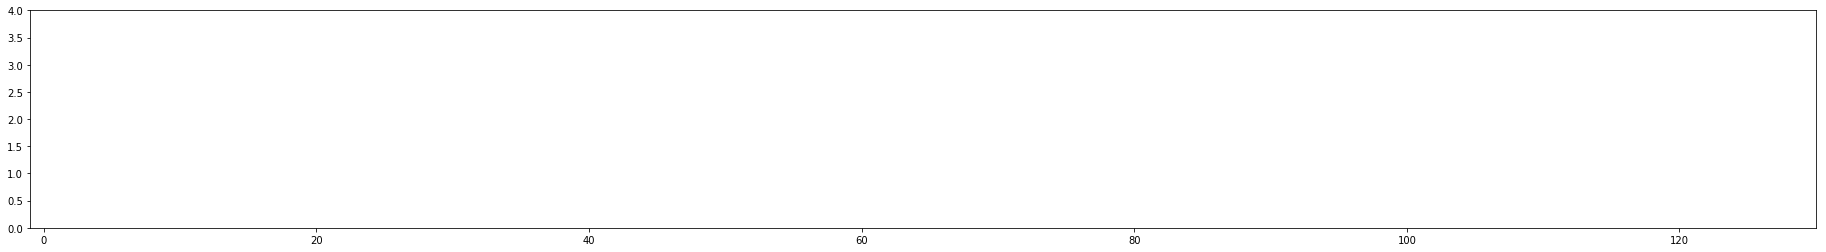

In [4]:
factorf=1.5
plt.figure(figsize=(2*nceldas,4))
plt.axis([-1, 8*nceldas+2, 0, 4])

mm=0.5 #<---------------------------------------

celdas=10
tita=0.1
datafolder=os.getcwd()+'/magnones-localizados/TLS/05/magnoncond'+'/L'+str(celdas)+'/tita'+str(tita)+'/delta'+str(delta)+'/'
archivo=datafolder+'parametros.task1.out.h5' #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

print('M/Msat = ',Data(archivo)[0]/(1.0*magnetizaciones))
ccc=Corr(archivo)
# ccc[0] -> labels
# ccc[1] -> parte real de S+S-
# ccc[2] -> parte imag de S+S-

# Recordar que la corriente tiene un signo mas porque lo estoy calculando usando la parte real e imag de la correlacion
# si la corriente se define como $$j_{a,b}=i(e^{i\theta}S^{+}S^{-}-e^{-i\theta}S^{-}S^{+})$$

#=====================================================
state=0           #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
#=====================================================

rc=2 
nsitios=nceldas*10

corrientestodas=[]


#borde izquierdo

corrientesintita=[2*(ccc[1][state][ik]*numpy.sin(0.0)+ccc[2][state][ik]*numpy.cos(0.0)) for ik in range(len(ccc[1][0]))]

# s1=1
# s2=3
# posco=poscorr(nceldas,s1,s2)
# flechav2(s1,s2,corrientesintita[posco])

# s1=3
# s2=4
# posco=poscorr(nceldas,s1,s2)
# flechav2(s1,s2,corrientesintita[posco])

# borde derecho

# s1=5*(nceldas-1)+2
# s2=5*(nceldas-1)+3
# posco=5*5*(nceldas-1)*(nceldas+1)+7
# flechav2(s1,s2,corrientesintita[posco])


# s1=5*(nceldas-1)+3
# s2=5*nceldas
# posco=5*5*(nceldas-1)*(nceldas+1)+14
# flechav2(s1,s2,corrientesintita[posco])


 
#borde superior

corrientesup=[2*(ccc[1][state][ik]*numpy.sin(tita)+ccc[2][state][ik]*numpy.cos(tita)) for ik in range(len(ccc[1][0]))]

for ii in range(nceldas):
    s1=10*ii+1
    s2=10*ii+2
    posco=poscorr(nceldas,1,2)
    flechav2(s1,s2,corrientesup[posco])
    
    s1=10*ii+2
    s2=10*ii+6
    posco=poscorr(nceldas,2,6)
    flechav2(s1,s2,corrientesup[posco])


    s1=10*ii+6
    s2=10*ii+7
    posco=poscorr(nceldas,6,7)
    flechav2(s1,s2,corrientesup[posco])

    #corrientestodas.append(corrientesup[posco])
    #print(corrientesup[posco])

for ii in range(nceldas-1):
    s1=10*ii+7
    s2=10*(ii+1)+1
    posco=poscorr2(nceldas,7,1)
    flechav2(s1,s2,corrientesup[posco])
    
    
#borde inferior

corrienteinf=[2*(ccc[1][state][ik]*numpy.sin(-1.0*tita)+ccc[2][state][ik]*numpy.cos(-1.0*tita)) for ik in range(len(ccc[1][0]))]

for ii in range(nceldas):
    s2=10*ii+4
    s1=10*ii+5
    posco=poscorr(nceldas,4,5)
    flechav2(s1,s2,corrienteinf[posco])

    s2=10*ii+5
    s1=10*ii+9
    posco=poscorr(nceldas,5,9)
    flechav2(s1,s2,corrienteinf[posco])

    s2=10*ii+9
    s1=10*ii+10
    posco=poscorr(nceldas,9,10)
    flechav2(s1,s2,corrienteinf[posco])
    
    #corrientestodas.append(corrienteinf[posco])
    #print(s2,s1,corrienteinf[posco])
    

for ii in range(nceldas-1):
    s1=10*ii+10
    s2=10*(ii+1)+4
    posco=poscorr2(nceldas,10,4)
    flechav2(s1,s2,corrienteinf[posco])
    #corrientestodas.append(corrienteinf[posco])
    
    
#corrientes internas
for ii in range(0,nceldas):
    s1=10*ii+1
    s2=10*ii+3
    posco=poscorr(nceldas,1,3)
    flechaint(s1,s2,corrientesintita[posco])

    s1=10*ii+3
    s2=10*ii+5
    posco=poscorr(nceldas,3,5)
    flechaint(s1,s2,corrientesintita[posco])
    
    s1=10*ii+6
    s2=10*ii+8
    posco=poscorr(nceldas,6,8)
    flechaint(s1,s2,corrientesintita[posco])

    s1=10*ii+8
    s2=10*ii+10
    posco=poscorr(nceldas,8,10)
    flechaint(s1,s2,corrientesintita[posco])

    s1=10*ii+2
    s2=10*ii+3
    posco=poscorr(nceldas,2,3)
    flechaint(s1,s2,corrientesintita[posco])

    s1=10*ii+3
    s2=10*ii+4
    posco=poscorr(nceldas,3,4)
    flechaint(s1,s2,corrientesintita[posco])

    s1=10*ii+7
    s2=10*ii+8
    posco=poscorr(nceldas,7,8)
    flechaint(s1,s2,corrientesintita[posco])

    s1=10*ii+9
    s2=10*ii+8
    posco=poscorr(nceldas,8,9)
    flechaint(s1,s2,corrientesintita[posco])

    
# for ii in range(0,nceldas-1):
#     s1=5*ii+3
#     s2=5*ii+5
#     posco=poscorr(nceldas,s1,s2)
#     flechaint(s1,s2,corrientesintita[posco])
    
# for ii in range(0,nceldas-1):
#     s1=5*ii+2
#     s2=5*ii+3
#     posco=poscorr(nceldas,s1,s2)
#     flechaint(s1,s2,corrientesintita[posco])
    
# for ii in range(1,nceldas):
#     s1=5*ii+3
#     s2=5*ii+4
#     posco=poscorr(nceldas,s1,s2)
#     flechaint(s1,s2,corrientesintita[posco])
    
    
    
#circulos 

fig = plt.gcf()
ax = fig.gca()    


for ii in range(0,nsitios):
    circle1 = plt.Circle(possitio(nceldas,ii+1),0.1,color='blue')
    ax.add_artist(circle1)

#plt.savefig(os.getcwd()+'/figcurrents'+'/L'+str(celdas)+'.pdf')
    
plt.show()

In [21]:

s1=10*ii+8
s2=10*ii+9
posco=poscorr(nceldas,8,9)
corrientesintita[posco]

0.014556100718901861

In [34]:
archivo=datafolder+'parametros.task1.out.h5'
Data2(archivo)

(8, array([1.4142592]))

In [29]:
lolo=currentparam(datafolder)
oP=orderP(datafolder)
oA=orderA(datafolder)
ohex=orderAhex(datafolder)
plt.figure()
#plt.plot(lolo[0],lolo[1],color='black')
#plt.scatter(lolo[0],lolo[1],color='black')
plt.plot(oP[0],oP[1],color='blue')
plt.scatter(oP[0],oP[1],color='blue')
plt.plot(oA[0],oA[1],color='red')
plt.scatter(oA[0],oA[1],color='red')
plt.plot(ohex[0],ohex[1],color='green')
plt.scatter(ohex[0],ohex[1],color='green')

#plt.ylim(0.0,0.1)

#plt.scatter(lolo[0],lolo[1])
#plt.savefig(graphfolder+'tita'+str(tita)+'delta'+str(delta)+'magcond.pdf')
plt.show()

IndexError: list index out of range

# Finite size scaling for the order parameters

In [19]:
mm=0.8 #<---------------------------------------
tita=0.1
delta=1.0

tamagnos=[4,6,12,14]
scaling=[]
for ll in tamagnos:
    nceldas=celdas=ll
    
    datafolder2=os.getcwd()+'/magnones-localizados/LP/08/magnoncond'+'/L'+str(ll)+'/tita'+str(tita)+'/delta'+str(delta)+'/'

    #archivo=datafolder2+'parametros.task'+str(indicefile(mm))+'.out.h5' #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    archivo=datafolder2+'parametros.task1.out.h5' #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    #ccc=Corr(archivo)
    #lolo=currentparam(datafolder)
    #oP=orderP(datafolder2)
    #oP=orderA(datafolder2)
    oP=orderAhex(datafolder2)
    scaling.append([1.0/ll,oP[1][0]])    
    print(ll)
    
scaling2=numpy.array(scaling)
scaling3=scaling2.T



# print('M/Msat = ',Data(archivo)[0]/(1.0*magnetizaciones))
# print(oP[0][indicefile(mm)-1])
# print(oP[1][indicefile(mm)-1])



4
6
12
14


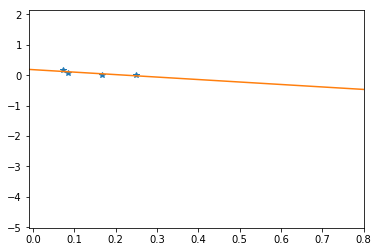

In [21]:
res = numpy.polyfit(scaling3[0],scaling3[1],1)
res
p = numpy.poly1d(res)

xp = numpy.linspace(-2, 6, 100)
plt.plot(scaling3[0], scaling3[1], '*', xp, p(xp), '-')
plt.xlim(-.01,.8)
#plt.ylim(-.25,.8)
plt.show()

('M/Msat = ', 28)


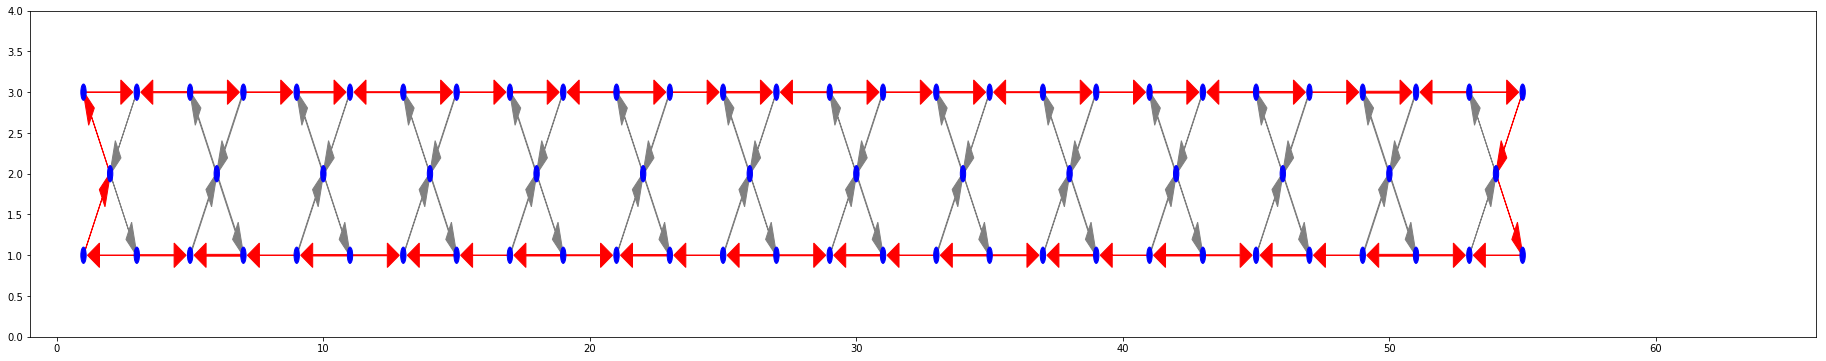

In [23]:
factorf=1.5
plt.figure(figsize=(2*nceldas,6))
plt.axis([-1, 4*nceldas+2, 0, 4])

mm=0.8 #<---------------------------------------
celdas=nceldas=14
datafolder=os.getcwd()+'/magnones-localizados/LP/08/magnoncond'+'/L'+str(celdas)+'/tita'+str(tita)+'/delta'+str(delta)+'/'
archivo=datafolder+'parametros.task1.out.h5' #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

print('M/Msat = ',Data(archivo)[0])
ccc=Corr(archivo)
# ccc[0] -> labels
# ccc[1] -> parte real de S+S-
# ccc[2] -> parte imag de S+S-

# Recordar que la corriente tiene un signo mas porque lo estoy calculando usando la parte real e imag de la correlacion
# si la corriente se define como $$j_{a,b}=i(e^{i\theta}S^{+}S^{-}-e^{-i\theta}S^{-}S^{+})$$

rc=2 
nsitios=nceldas*5

corrientestodas=[]
state=0

#borde izquierdo
corrientesintita=[2*(ccc[1][state][ik]*numpy.sin(0.0)+ccc[2][state][ik]*numpy.cos(0.0)) for ik in range(len(ccc[1][0]))]

s1=1
s2=3
posco=2
flechav2(s1,s2,corrientesintita[posco])
#corrientestodas.append(corrientesintita[posco])

s1=3
s2=4
posco=13
flechav2(s1,s2,corrientesintita[posco])
#corrientestodas.append(corrientesintita[posco])

# borde derecho

s1=5*(nceldas-1)+2
s2=5*(nceldas-1)+3
posco=5*5*(nceldas-1)*(nceldas+1)+7
flechav2(s1,s2,corrientesintita[posco])
#corrientestodas.append(corrientesintita[posco])

s1=5*(nceldas-1)+3
s2=5*nceldas
posco=5*5*(nceldas-1)*(nceldas+1)+14
flechav2(s1,s2,corrientesintita[posco])
#corrientestodas.append(corrientesintita[posco])

 
#borde superior

corrientesup=[2*(ccc[1][state][ik]*numpy.sin(tita)+ccc[2][state][ik]*numpy.cos(tita)) for ik in range(len(ccc[1][0]))]

for ii in range(nceldas):
    s1=5*ii+1
    s2=5*ii+2
    posco=ii*5*5*(nceldas+1)+1
    flechav2(s1,s2,corrientesup[posco])
    corrientestodas.append(corrientesup[posco])
    #print(corrientesup[posco])

for ii in range(nceldas-1):
    s1=5*ii+2
    s2=5*(ii+1)+1
    posco=ii*5*5*(nceldas+1)+(5*5)+5
    flechav2(s1,s2,corrientesup[posco])
    corrientestodas.append(corrientesup[posco])
    
    
#borde inferior

corrienteinf=[2*(ccc[1][state][ik]*numpy.sin(-1.0*tita)+ccc[2][state][ik]*numpy.cos(-1.0*tita)) for ik in range(len(ccc[1][0]))]

for ii in range(nceldas):
    s2=5*ii+4
    s1=5*ii+5
    posco=19+ii*5*5*(nceldas+1)
    flechav2(s2,s1,corrienteinf[posco])
    #corrientestodas.append(corrienteinf[posco])
    #print(s2,s1,corrienteinf[posco])
    

for ii in range(nceldas-1):
    s1=5*ii+5
    s2=5*(ii+1)+4
    posco=ii*5*5*(nceldas+1)+5*5+23
    flechav2(s1,s2,corrienteinf[posco])
    #corrientestodas.append(corrienteinf[posco])
    
    
#corrientes internas
for ii in range(1,nceldas):
    s1=5*ii+1
    s2=5*ii+3
    posco=ii*5*5*(nceldas+1)+2
    flechaint(s1,s2,corrientesintita[posco])

for ii in range(0,nceldas-1):
    s1=5*ii+3
    s2=5*ii+5
    posco=ii*5*5*(nceldas+1)+14
    flechaint(s1,s2,corrientesintita[posco])
    
for ii in range(0,nceldas-1):
    s1=5*ii+2
    s2=5*ii+3
    posco=ii*5*5*(nceldas+1)+7
    flechaint(s1,s2,corrientesintita[posco])
    
for ii in range(1,nceldas):
    s1=5*ii+3
    s2=5*ii+4
    posco=ii*5*5*(nceldas+1)+13
    flechaint(s1,s2,corrientesintita[posco])
    
    
    
#circulos 

fig = plt.gcf()
ax = fig.gca()    


for ii in range(0,nsitios):
    circle1 = plt.Circle(possitio(nceldas,ii+1),0.1,color='blue')
    ax.add_artist(circle1)

plt.savefig(os.getcwd()+'/figcurrents'+'/L'+str(celdas)+'.pdf')
    
plt.show()


# Notes













# Hamiltonian

We use the Hamiltonian
\begin{eqnarray}
\label{eq:H}
H=\sum_{i,j}J_{i,j}(e^{i\theta_{i,j}}S^{+}_{i}S^{-}_{j}+e^{-i\theta_{i,j}}S^{-}_{i}S^{+}_{j}+\Delta_{i,j}S^{z}_{i}S^{z}_{j})
\end{eqnarray}.

![celda unidad](unitcell.png)

The gauge $\theta_{i,j}$ is taken as non-zero in the legs. The Hamiltonian can be written also as
$$H=\sum_{i,j}J_{i,j}\left(\cos(\theta_{i,j})(S^{+}_{i}S^{-}_{j}+S^{-}_{i}S^{+}_{j})+i\sin(\theta_{i,j})(S^{+}_{i}S^{-}_{j}-S^{-}_{i}S^{+}_{j})+\Delta_{i,j}S^{z}_{i}S^{z}_{j}\right)$$.


## Find tuning for localized magnons

The magnon state in the Hexagon is an eigenstate of the Hamiltonian only if the couplings satisfy 
$$ J_2 =\frac{(2\Delta +1)}{(\Delta +1)}J_1$$ 

We are going to determine the current $$j_{a,b}=i(e^{i\theta}S^{+}S^{-}-e^{-i\theta}S^{-}S^{+})$$

The localized magnon state is an eigenstate of the Hamiltonian (\ref{eq:H}) only if $\theta = \frac{\pi}{4}n$, with $n=0,1,2...$.
In the case $\theta=0$ the localized magnons represents the ground state at $\frac{M}{M_{sat}}=\frac{4}{5}$.

In this case, we study the influence of a small gauge $\theta$ in the ground state.

For $\theta= \frac{\pi}{4}$ the magnon is not any more the ground state but an exited state. 



## Correlaciones

In [ ]:
import sys 
import os
import numpy
import h5py
import matplotlib.pyplot as plt
import datatoolsdmrg as dt # modulo para levantar los datos del h5

from definitionsDM import Data
from definitionsDM import hs
from definitionsDM import result
from definitionsDM import flechav2
from definitionsDM import Corr
from definitionsDM import currentparam
from definitionsDM import possitio

In [ ]:
def Corr(file):
    """extrae la magnetizacion y la energia del gs"""
    h5files=h5py.File(file,'r')
    #labels=h5files['spectrum/results/RealPart/labels'].value
    #realcorr=h5files['spectrum/results/RealPart/mean/value'].value
    complexcorr=h5files['spectrum/results/ComplexPart/mean/value'].value
    return complexcorr

In [6]:

def parametros(file):
#     energias=[]
    """extrae la magnetizacion y la energia del gs"""
    h5files=h5py.File(file,'r')# abre el file
    j2=str(h5files['parameters/J2'].value)
    lx=str(h5files['parameters/L'].value)    
    m=h5files['parameters/Sz_total'].value
    diccio={'J2':float(j2),'Lx':float(lx),'m':float(m)}
    return diccio



   
def Corr(file):
    """extrae las correlaciones"""
    h5files=h5py.File(file,'r')
    corre=h5files['spectrum/results/Diagonal spin correlations/mean/value'].value[0]   
     
    return corre



def datafiles(folder):
    f=[]
    for files in os.listdir(folder):
        if files.endswith('h5'):
            f.append(folder+'/'+files)            
    
    return f

:: Indice de sector = 17
.::: archivo :::.  
/home/carlos/Dropbox/1.Investigacion/actuales/cadena kagome/numerico/DMRG/Olimpo/diagrama1/L16/J20.5/J31.1/J40.8/parametros.task25.out.h5


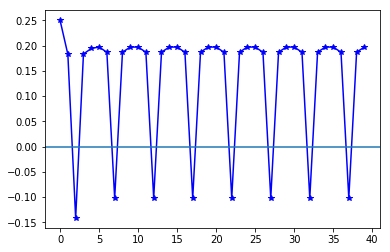

In [7]:
magnorm=0.6
datines=datafiles(datafolder) # Los nombres de todos los archivos de datos
sectores=[parametros(datis)['m']/mmax for datis in datines] # lista con las magnetizaciones normalizadas
sec2=[x for x in enumerate(sectores)] #duplas  de los sectores

print(':: Indice de sector = '+str(sectores.index(magnorm)))
print('.::: archivo :::.  ')
print(datines[sectores.index(magnorm)])

indicecorr=[25*n+i for n in range(8) for i in range(5)] # indice que hay que usar para recorrer los sitios de las correlaciones

correla=[Corr(datines[sectores.index(magnorm)])[l] for l in indicecorr]
correlabs=[numpy.abs(Corr(datines[sectores.index(magnorm)])[l]) for l in indicecorr]

plt.plot([i for i in range(len(correla))],correla,'*-',color='blue')
plt.axhline(y=0.0)


In [160]:
# viejo

In [173]:
?plt.axhline

In [125]:

correla=[Corr(datines[8])[25*n+i] for n in range(8) for i in range(5)]
correlabs=[numpy.abs(Corr(datines[8])[25*n+i]) for n in range(8) for i in range(5)]
indices=[i for i in range(len(correlacionesposta))]
ind2=[2*n+i for n in range(3) for i in range(5)]

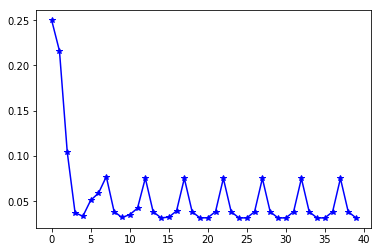

In [126]:
plt.plot([i for i in range(len(correla))],correlabs,'*-',color='blue')


In [127]:
correlabs

[0.24999999999999931,
 0.21606359872794415,
 0.1040055255303796,
 0.037208438720608507,
 0.033473516913324002,
 0.051103342632302977,
 0.058939529848036,
 0.07717943164085464,
 0.038636697417288486,
 0.032102513962020136,
 0.035146552846289703,
 0.042344698713222502,
 0.075492399608698579,
 0.038462962362595471,
 0.031724689129902735,
 0.0323453292141338,
 0.039261348152165393,
 0.075271071902195202,
 0.038416827414001174,
 0.031624325223472784,
 0.031753635735825278,
 0.038594140998460917,
 0.07523541049166789,
 0.03840465783293897,
 0.031597861337424524,
 0.031618558009488401,
 0.038439834858336172,
 0.075228981710622242,
 0.038401577497424157,
 0.031591056321372157,
 0.031586524465652355,
 0.038402958132706437,
 0.075227699053440261,
 0.038400799457298275,
 0.031589325807417204,
 0.031578889850058807,
 0.038394116338853104,
 0.075227399228176325,
 0.038400526711173492,
 0.03158883218484336]

In [69]:

imax=5
jmax=5
datos=[]
for i in range(0,imax+1):
    J3=0.2*i+0.6
#     graphfolder=os.getcwd()+'/diagrama1'+'/L'+str(celdas)+'/graficos/J3'+str(J3)+'/'
#     os.makedirs(graphfolder)
    for j in range(0,jmax+1):   
        J2=0.2*j+0.6
        datafolder=os.getcwd()+'/diagrama1'+'/L'+str(celdas)+'/J2'+str(J2)+'/J3'+str(J3)+'/J4'+str(J4)+'/'
        a,jotas=result2(datafolder)
        datos.append([jotas,a])
        

In [70]:
pla=[]
for i in datos:
    a=platos(i,campos)
    pla.append(a)
    
plat=numpy.array(pla)

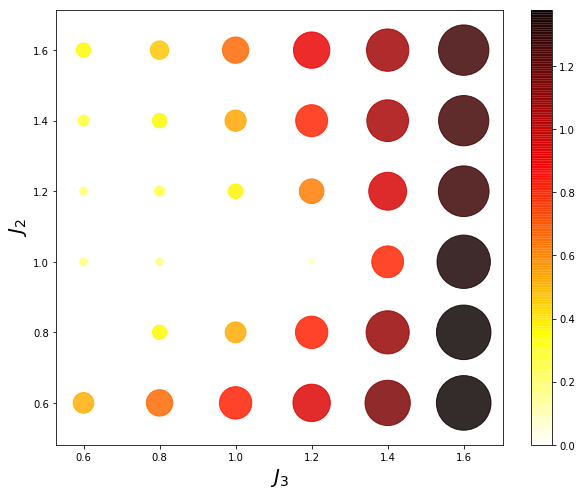

In [80]:


%matplotlib inline

plt.figure(figsize=(10,8))
plt.scatter(plat[:,0],plat[:,1],s=500*numpy.pi*plat[:,3]**2,c=plat[:,3],cmap='hot_r',alpha=.83)
plt.ylabel(r'$J_2$',fontsize=20)
plt.xlabel(r'$J_3$',fontsize=20)
plt.colorbar()

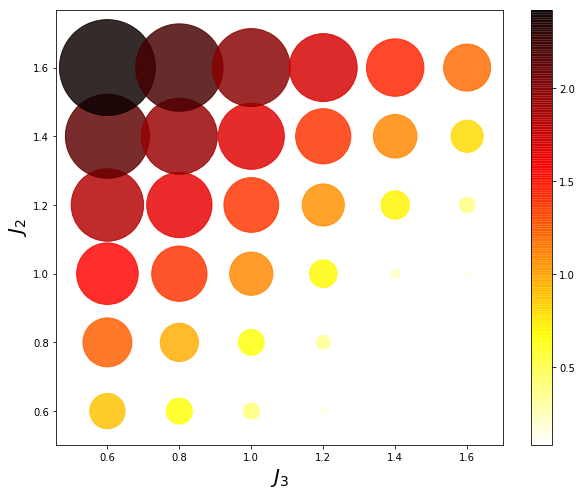

In [83]:

%matplotlib inline

plt.figure(figsize=(10,8))
plt.scatter(plat[:,0],plat[:,1],s=500*numpy.pi*plat[:,4]**2,c=plat[:,4],cmap='hot_r',alpha=.83)
plt.ylabel(r'$J_2$',fontsize=20)
plt.xlabel(r'$J_3$',fontsize=20)
plt.colorbar()

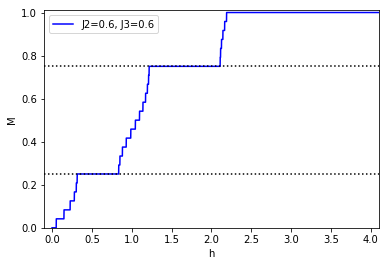

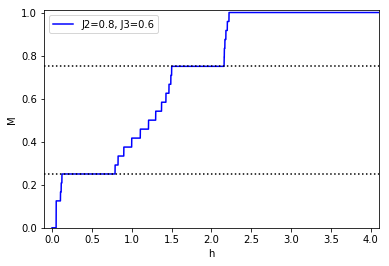

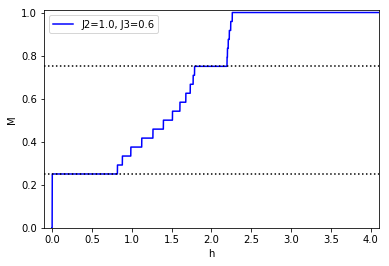

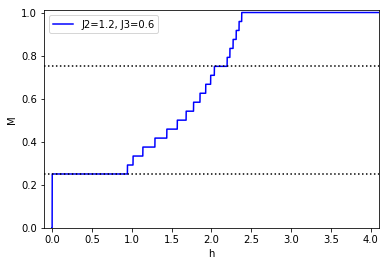

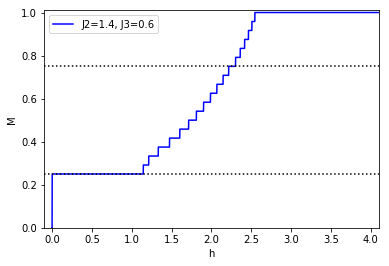

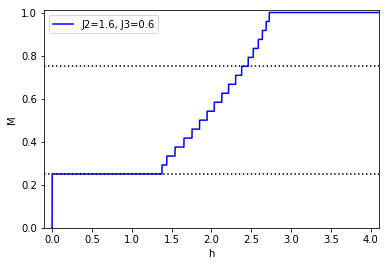

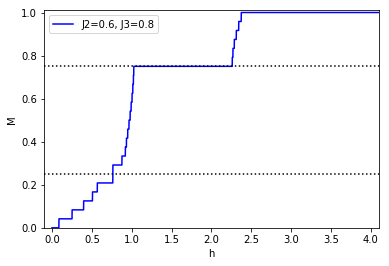

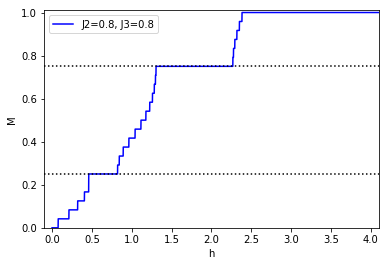

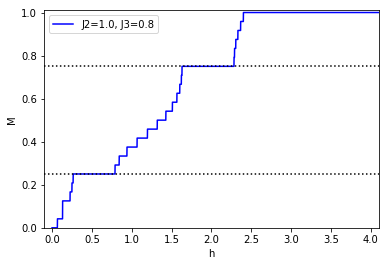

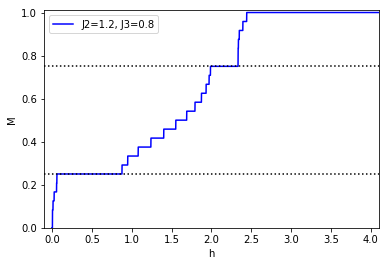

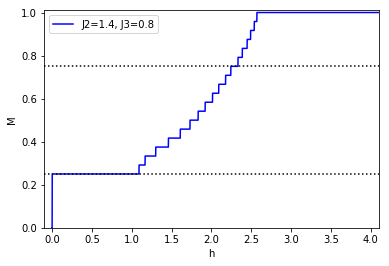

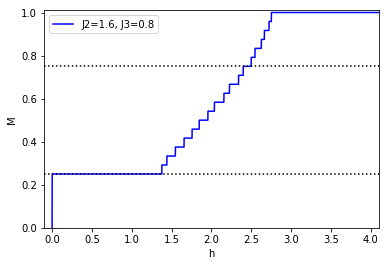

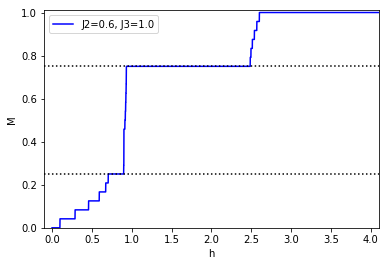

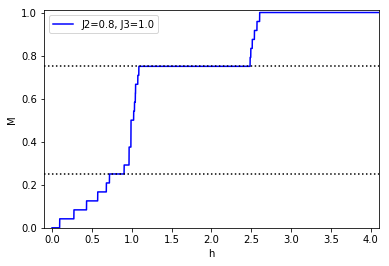

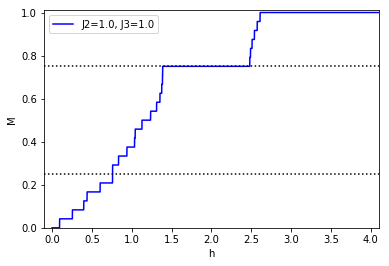

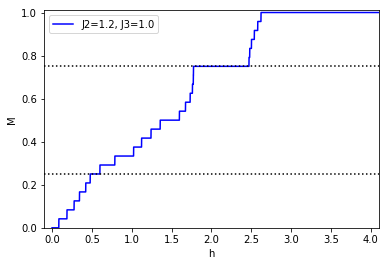

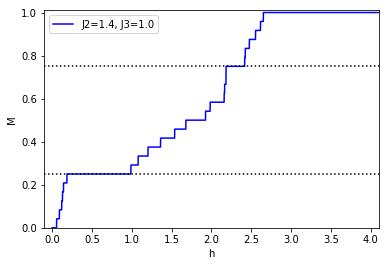

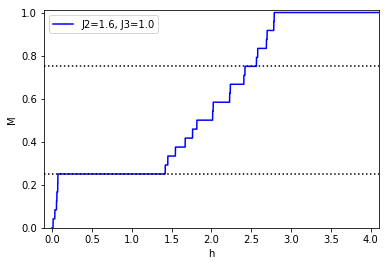

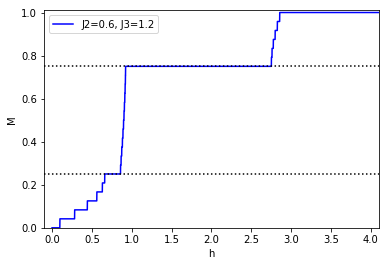

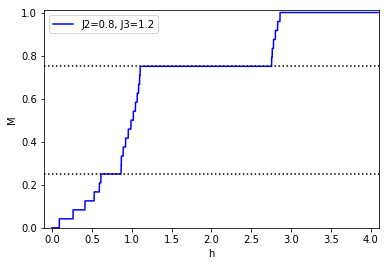

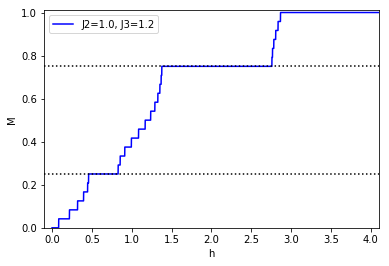

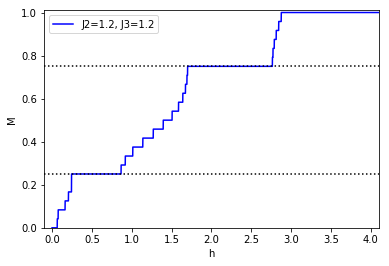

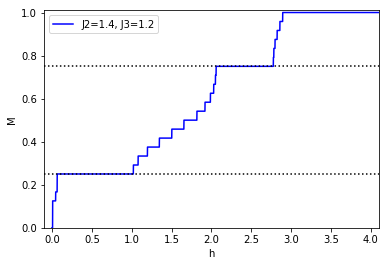

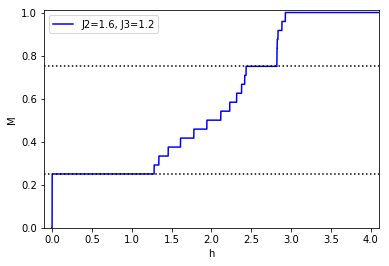

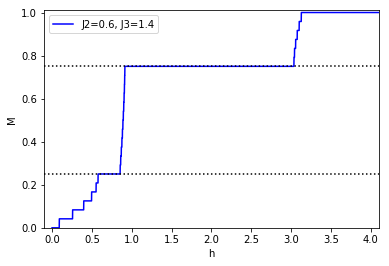

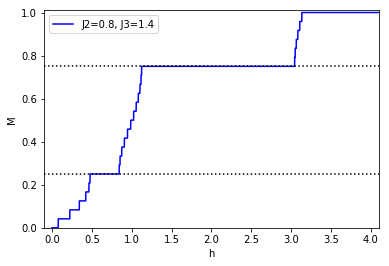

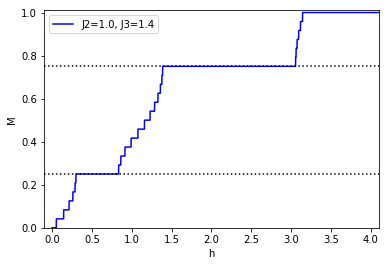

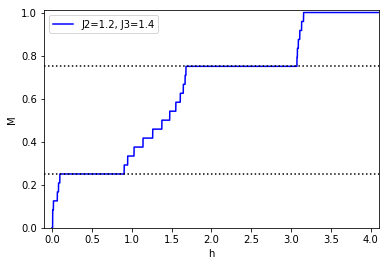

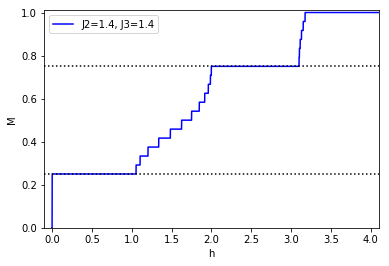

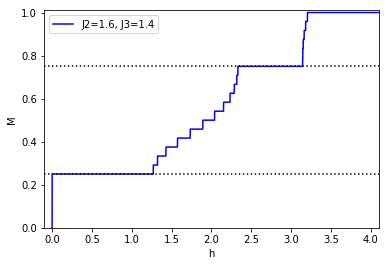

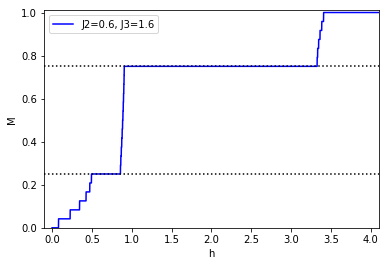

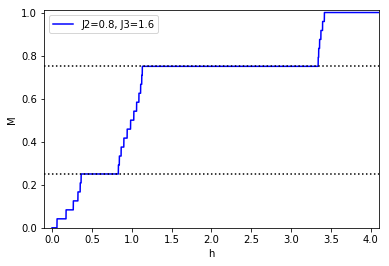

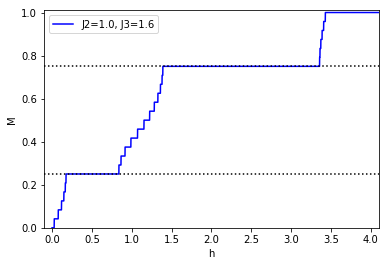

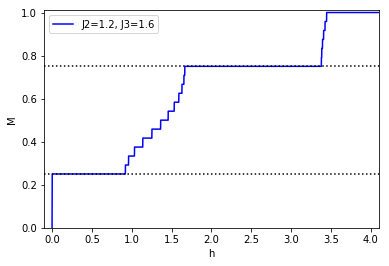

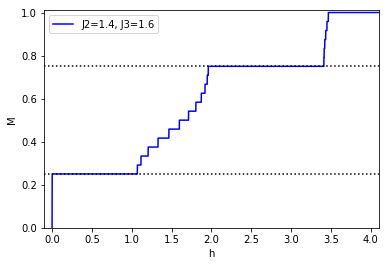

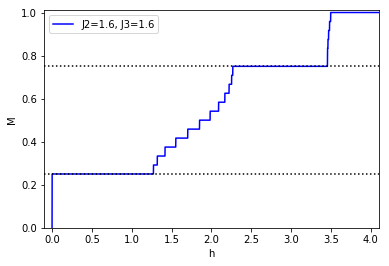

In [3]:
#looooooop

celdas=12  # number of sites 4*celdas
spin=1/2 
J1=1.0
J2=1.6
J3=0.6
J4=0.8


imax=5
jmax=5

graphfolder=os.getcwd()+'/diagrama1'+'/L'+str(celdas)+'/graficos/'
os.system('rm -r '+graphfolder)
os.makedirs(graphfolder)

for i in range(0,imax+1):
    J3=0.2*i+0.6
    graphfolder=os.getcwd()+'/diagrama1'+'/L'+str(celdas)+'/graficos/J3'+str(J3)+'/'
    os.makedirs(graphfolder)
    for j in range(0,jmax+1):   
        J2=0.2*j+0.6   


        magnetizaciones=(5/2)*celdas; # 5 sitios por celda con s=1/2
        mmax=magnetizaciones
        # defino la ruta a la carpeta donde voy a guardar los resultados
        #datafolder=os.getcwd()+'/diagrama1/L'+str(celdas)+'/graficos'+'/'
        datafolder=os.getcwd()+'/diagrama1'+'/L'+str(celdas)+'/J2'+str(J2)+'/J3'+str(J3)+'/J4'+str(J4)+'/'
        
        
        
        # con la funci'on result incluido en el m'odulo datatoolsdmrg levanto los resultados para la energia del gs
        # correspondiente a cada sector de magnetizacion
        dd=numpy.sort(dt.result(datafolder),axis=0)

        campos=0.0005*numpy.array(range(0,15000)) #lista de campos magneticos que le paso a hs
        mvsh=hs(dd,campos)

        plt.plot(mvsh[:,0],mvsh[:,1]/mmax,'-',color='blue', label="J2="+str(J2)+', J3='+str(J3))
        plt.xlabel('h')
        plt.ylabel('M')
        plt.ylim((0,1.01))
        plt.xlim((-0.1,4.1))
        #
        plt.axhline(y=(3.0/4.0), xmin=0, xmax=2, hold=None,color='black',linestyle='dotted')
        plt.axhline(y=(1.0/4.0), xmin=0, xmax=2, hold=None,color='black',linestyle='dotted')
        #plt.axvline(x=0.903759, ymin=0, ymax=1, hold=None,color='r',linestyle='dashed')
        plt.legend(loc='upper left')

        plt.savefig(graphfolder+'J2'+str(J2)+'J3'+str(J3)+'.pdf')
        #plt.savefig(graphfolder+'asd.pdf') # no encuentra el directorio y no puedo crearlo desde aca...
        plt.show()


In [4]:
?plt.scatter

In [3]:
imax=5
jmax=5
for i in range(0,1):
    J3=0.2*i+0.6
    for j in range(0,jmax+1):   
        J2=0.2*j+0.6  
        print J2,J3

0.6 0.6
0.8 0.6
1.0 0.6
1.2 0.6
1.4 0.6
1.6 0.6


## Ejemplo de como usar las correlaciones

In [7]:

def parametros(file):
#     energias=[]
    """extrae la magnetizacion y la energia del gs"""
    h5files=h5py.File(file,'r')# abre el file
    j2=str(h5files['parameters/J2'].value)
    lx=str(h5files['parameters/L'].value)    
    m=h5files['parameters/Sz_total'].value
    diccio={'J2':float(j2),'Lx':float(lx),'m':float(m)}
    return diccio



   
def Corr(file):
    """extrae las correlaciones"""
    h5files=h5py.File(file,'r')
    corre=h5files['spectrum/results/Diagonal spin correlations/mean/value'].value[0]   
     
    return corre


In [12]:
archivos=dt.Datafiles(datafolder) 

In [15]:
archivos[0]

'/home/s/Dropbox/Tesina-Acevedo/Alps/DMRG/fasesd0606/L12/J20.8/J31.0/J40.8//parametros.task11.out.h5'

In [17]:
print(Data(archivos[1]))

(0, -24.580233535483167)


In [11]:
par=parametros(archivos[0])
print(Data(archivos[0]))

(10, -17.97776952551792)


In [34]:
Corr(archivos[0])

array([ 0.25      , -0.2311102 , -0.0743459 , -0.01090072,  0.01089116,
       -0.2311102 ,  0.25      ,  0.05546566,  0.01089116, -0.01090072,
       -0.0743459 ,  0.05546566,  0.25      ,  0.05546566, -0.0743459 ,
       -0.01090072,  0.01089116,  0.05546566,  0.25      , -0.2311102 ,
        0.01089116, -0.01090072, -0.0743459 , -0.2311102 ,  0.25      ,
       -0.01230576,  0.01649458,  0.04708802,  0.01649458, -0.01230576,
        0.01649458, -0.02210925, -0.06311655, -0.02210925,  0.01649458,
        0.04708802, -0.06311655, -0.18018247, -0.06311655,  0.04708802,
        0.01649458, -0.02210925, -0.06311655, -0.02210925,  0.01649458,
       -0.01230576,  0.01649458,  0.04708802,  0.01649458, -0.01230576,
       -0.01230576,  0.01649458,  0.04708802,  0.01649458, -0.01230576,
        0.01649458, -0.02210925, -0.06311655, -0.02210925,  0.01649458,
        0.04708802, -0.06311655, -0.18018247, -0.06311655,  0.04708802,
        0.01649458, -0.02210925, -0.06311655, -0.02210925,  0.01

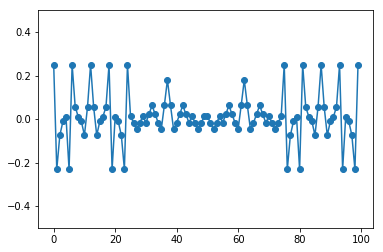

In [37]:
nfile=1
coco=Corr(archivos[nfile])
co=[coco[1],coco[4],coco[5],coco[8]]
num=[i for i in range(len(coco))]

plt.figure()
plt.scatter(num,coco)
plt.ylim(-0.5,0.5)
plt.plot(num,coco)
plt.show()